<a href="https://colab.research.google.com/github/BoyoungH/2D-to-3D-Nerf/blob/main/tiny_nerf_use_bbox_algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from torch import nn, optim


def get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os):
    # Sample depths (t_is_c). See Equation (2) in Section 4.
    u_is_c = torch.rand(*list(ds.shape[:2]) + [N_c]).to(ds)
    t_is_c = t_i_c_bin_edges + u_is_c * t_i_c_gap
    # Calculate the points along the rays (r_ts_c) using the ray origins (os), sampled
    # depths (t_is_c), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_c = os[..., None, :] + t_is_c[..., :, None] * ds[..., None, :]
    return (r_ts_c, t_is_c)


def get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds):
    # See text surrounding Equation (5) in Section 5.2 and:
    # https://stephens999.github.io/fiveMinuteStats/inverse_transform_sampling.html#discrete_distributions.

    # Define PDFs (pdfs) and CDFs (cdfs) from weights (w_is_c).
    w_is_c = w_is_c + 1e-5
    pdfs = w_is_c / torch.sum(w_is_c, dim=-1, keepdim=True)
    cdfs = torch.cumsum(pdfs, dim=-1)
    cdfs = torch.cat([torch.zeros_like(cdfs[..., :1]), cdfs[..., :-1]], dim=-1)

    # Get uniform samples (us).
    us = torch.rand(list(cdfs.shape[:-1]) + [N_f]).to(w_is_c)

    # Use inverse inverse transform sampling to sample the depths (t_is_f).
    idxs = torch.searchsorted(cdfs, us, right=True)
    t_i_f_bottom_edges = torch.gather(t_is_c, 2, idxs - 1)
    idxs_capped = idxs.clone()
    max_ind = cdfs.shape[-1]
    idxs_capped[idxs_capped == max_ind] = max_ind - 1
    t_i_f_top_edges = torch.gather(t_is_c, 2, idxs_capped)
    t_i_f_top_edges[idxs == max_ind] = t_f
    t_i_f_gaps = t_i_f_top_edges - t_i_f_bottom_edges
    u_is_f = torch.rand_like(t_i_f_gaps).to(os)
    t_is_f = t_i_f_bottom_edges + u_is_f * t_i_f_gaps

    # Combine the coarse (t_is_c) and fine (t_is_f) depths and sort them.
    (t_is_f, _) = torch.sort(torch.cat([t_is_c, t_is_f.detach()], dim=-1), dim=-1)
    # Calculate the points along the rays (r_ts_f) using the ray origins (os), depths
    # (t_is_f), and ray directions (ds). See Section 4: r(t) = o + t * d.
    r_ts_f = os[..., None, :] + t_is_f[..., :, None] * ds[..., None, :]
    return (r_ts_f, t_is_f)


def render_radiance_volume(r_ts, ds, chunk_size, F, t_is):
    # Use the network (F) to predict colors (c_is) and volume densities (sigma_is) for
    # 3D points along rays (r_ts) given the viewing directions (ds) of the rays. See
    # Section 3 and Figure 7 in the Supplementary Materials.
    r_ts_flat = r_ts.reshape((-1, 3))
    ds_rep = ds.unsqueeze(2).repeat(1, 1, r_ts.shape[-2], 1)
    ds_flat = ds_rep.reshape((-1, 3))
    c_is = []
    sigma_is = []
    # The network processes batches of inputs to avoid running out of memory.
    for chunk_start in range(0, r_ts_flat.shape[0], chunk_size):
        r_ts_batch = r_ts_flat[chunk_start : chunk_start + chunk_size]
        ds_batch = ds_flat[chunk_start : chunk_start + chunk_size]
        preds = F(r_ts_batch, ds_batch)
        c_is.append(preds["c_is"])
        sigma_is.append(preds["sigma_is"])

    c_is = torch.cat(c_is).reshape(r_ts.shape)
    sigma_is = torch.cat(sigma_is).reshape(r_ts.shape[:-1])

    # Calculate the distances (delta_is) between points along the rays. The differences
    # in depths are scaled by the norms of the ray directions to get the final
    # distances. See text following Equation (3) in Section 4.
    delta_is = t_is[..., 1:] - t_is[..., :-1]
    # "Infinity". Guarantees last alpha is always one.
    one_e_10 = torch.Tensor([1e10]).expand(delta_is[..., :1].shape)
    delta_is = torch.cat([delta_is, one_e_10.to(delta_is)], dim=-1)
    delta_is = delta_is * ds.norm(dim=-1).unsqueeze(-1)

    # Calculate the alphas (alpha_is) of the 3D points using the volume densities
    # (sigma_is) and distances between points (delta_is). See text following Equation
    # (3) in Section 4 and https://en.wikipedia.org/wiki/Alpha_compositing.
    alpha_is = 1.0 - torch.exp(-sigma_is * delta_is)

    # Calculate the accumulated transmittances (T_is) along the rays from the alphas
    # (alpha_is). See Equation (3) in Section 4. T_i is "the probability that the ray
    # travels from t_n to t_i without hitting any other particle".
    T_is = torch.cumprod(1.0 - alpha_is + 1e-10, -1)
    # Guarantees the ray makes it at least to the first step. See:
    # https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L142,
    # which uses tf.math.cumprod(1.-alpha + 1e-10, axis=-1, exclusive=True).
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    # Calculate the weights (w_is) for the colors (c_is) along the rays using the
    # transmittances (T_is) and alphas (alpha_is). See Equation (5) in Section 5.2:
    # w_i = T_i * (1 - exp(-sigma_i * delta_i)).
    w_is = T_is * alpha_is

    # Calculate the pixel colors (C_rs) for the rays as weighted (w_is) sums of colors
    # (c_is). See Equation (5) in Section 5.2: C_c_hat(r) = Σ w_i * c_i.
    C_rs = (w_is[..., None] * c_is).sum(dim=-2)

    return (C_rs, w_is)


def run_one_iter_of_nerf(
    ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
):
    (r_ts_c, t_is_c) = get_coarse_query_points(ds, N_c, t_i_c_bin_edges, t_i_c_gap, os)
    (C_rs_c, w_is_c) = render_radiance_volume(r_ts_c, ds, chunk_size, F_c, t_is_c)

    (r_ts_f, t_is_f) = get_fine_query_points(w_is_c, N_f, t_is_c, t_f, os, ds)
    (C_rs_f, _) = render_radiance_volume(r_ts_f, ds, chunk_size, F_f, t_is_f)

    return (C_rs_c, C_rs_f)


class NeRFMLP(nn.Module):
    def __init__(self):
        super().__init__()
        # Number of encoding functions for positions. See Section 5.1.
        self.L_pos = 10
        # Number of encoding functions for viewing directions. See Section 5.1.
        self.L_dir = 4
        pos_enc_feats = 3 + 3 * 2 * self.L_pos
        dir_enc_feats = 3 + 3 * 2 * self.L_dir

        in_feats = pos_enc_feats
        net_width = 256
        early_mlp_layers = 1 #5
        early_mlp = []
        for layer_idx in range(early_mlp_layers):
            early_mlp.append(nn.Linear(in_feats, net_width))
            early_mlp.append(nn.ReLU())
            in_feats = net_width

        self.early_mlp = nn.Sequential(*early_mlp)

        in_feats = pos_enc_feats + net_width
        late_mlp_layers = 1 #3
        late_mlp = []
        for layer_idx in range(late_mlp_layers):
            late_mlp.append(nn.Linear(in_feats, net_width))
            late_mlp.append(nn.ReLU())
            in_feats = net_width

        self.late_mlp = nn.Sequential(*late_mlp)
        self.sigma_layer = nn.Linear(net_width, net_width + 1)
        self.pre_final_layer = nn.Sequential(
            nn.Linear(dir_enc_feats + net_width, net_width // 2), nn.ReLU()
        )
        self.final_layer = nn.Sequential(nn.Linear(net_width // 2, 3), nn.Sigmoid())

    def forward(self, xs, ds):
        # Encode the inputs. See Equation (4) in Section 5.1.
        xs_encoded = [xs]
        for l_pos in range(self.L_pos):
            xs_encoded.append(torch.sin(2 ** l_pos * torch.pi * xs))
            xs_encoded.append(torch.cos(2 ** l_pos * torch.pi * xs))

        xs_encoded = torch.cat(xs_encoded, dim=-1)

        ds = ds / ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds_encoded = [ds]
        for l_dir in range(self.L_dir):
            ds_encoded.append(torch.sin(2 ** l_dir * torch.pi * ds))
            ds_encoded.append(torch.cos(2 ** l_dir * torch.pi * ds))

        ds_encoded = torch.cat(ds_encoded, dim=-1)

        # Use the network to predict colors (c_is) and volume densities (sigma_is) for
        # 3D points (xs) along rays given the viewing directions (ds) of the rays. See
        # Section 3 and Figure 7 in the Supplementary Materials.
        outputs = self.early_mlp(xs_encoded)
        outputs = self.late_mlp(torch.cat([xs_encoded, outputs], dim=-1))
        outputs = self.sigma_layer(outputs)
        sigma_is = torch.relu(outputs[:, 0])
        outputs = self.pre_final_layer(torch.cat([ds_encoded, outputs[:, 1:]], dim=-1))
        c_is = self.final_layer(outputs)
        return {"c_is": c_is, "sigma_is": sigma_is}

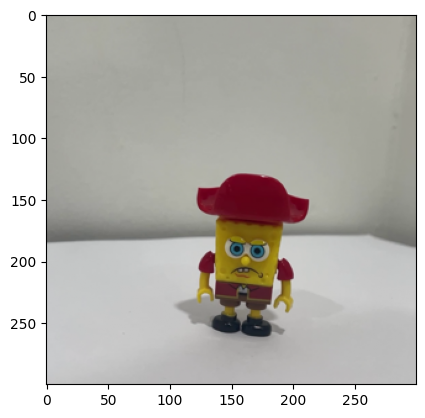

NeRFMLP(
  (early_mlp): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
  )
  (late_mlp): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
  )
  (sigma_layer): Linear(in_features=256, out_features=257, bias=True)
  (pre_final_layer): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
  )
  (final_layer): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [ ]:
# Set seed.
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Initialize coarse and fine MLPs.
device = "cuda:0"
F_c = NeRFMLP().to(device)
F_f = NeRFMLP().to(device)
# Number of query points passed through the MLP at a time. See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L488.
chunk_size = 1024 * 32
# Number of training rays per iteration. See Section 5.3.
batch_img_size = 64
n_batch_pix = batch_img_size ** 2

# Initialize optimizer. See Section 5.3.
lr = 5e-4
optimizer = optim.Adam(list(F_c.parameters()) + list(F_f.parameters()), lr=lr)
criterion = nn.MSELoss()
# The learning rate decays exponentially. See Section 5.3
# See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L486.
lrate_decay = 250
decay_steps = lrate_decay * 1000
# See: https://github.com/bmild/nerf/blob/18b8aebda6700ed659cb27a0c348b737a5f6ab60/run_nerf.py#L707.
decay_rate = 0.1

# Load dataset.
data_f = "/content/drive/MyDrive/spongee.npz"
data = np.load(data_f)

# Set up initial ray origin (init_o) and ray directions (init_ds). These are the
# same across samples, we just rotate them based on the orientation of the camera.
# See Section 4.
images = data["rgb"] #/ 255
img_size = images.shape[1]
xs = torch.arange(img_size) - (img_size / 2 - 0.5)
ys = torch.arange(img_size) - (img_size / 2 - 0.5)
(xs, ys) = torch.meshgrid(xs, -ys, indexing="xy")
focal = float(data["focal"])
pixel_coords = torch.stack([xs, ys, torch.full_like(xs, -focal)], dim=-1)
# We want the zs to be negative ones, so we divide everything by the focal length
# (which is in pixel units).
camera_coords = pixel_coords / focal
init_ds = camera_coords.to(device)
init_o = torch.Tensor(np.array([0, 0, 2.25])).to(device) #float(data["camera_distance"])

# Set up test view.
test_idx =29 #150
plt.imshow(images[test_idx])
plt.show()
test_img = torch.Tensor(images[test_idx]).to(device)
poses = data["poses"]
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)

# Initialize volume rendering hyperparameters.
# Near bound. See Section 4.
t_n = 1.0
# Far bound. See Section 4.
t_f = 4.0
# Number of coarse samples along a ray. See Section 5.3.
N_c = 64
# Number of fine samples along a ray. See Section 5.3.
N_f = 128
# Bins used to sample depths along a ray. See Equation (2) in Section 4.
t_i_c_gap = (t_f - t_n) / N_c
t_i_c_bin_edges = (t_n + torch.arange(N_c) * t_i_c_gap).to(device)

# Start training model.
train_idxs = np.arange(len(images)) != test_idx
images = torch.Tensor(images[train_idxs])
poses = torch.Tensor(poses[train_idxs])
n_pix = img_size ** 2
pixel_ps = torch.full((n_pix,), 1 / n_pix).to(device)
psnrs = []
iternums = []
# See Section 5.3.
num_iters = 500
display_every = 100
F_c.train()
F_f.train()


In [ ]:
!nvidia-smi

Fri May 12 06:31:08 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |    139MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Loss: 0.2812512516975403


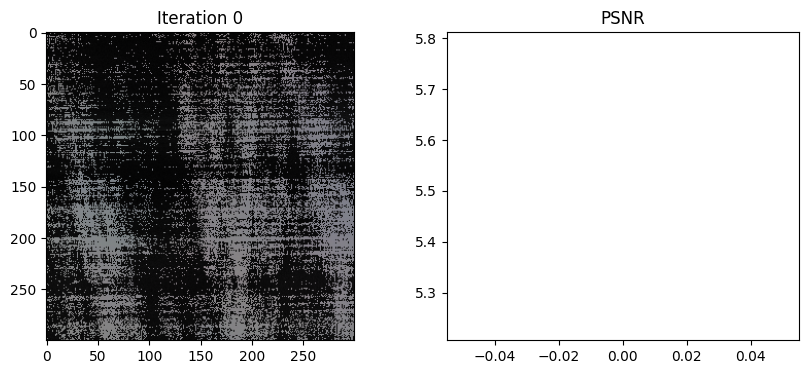

Loss: 0.021628623828291893


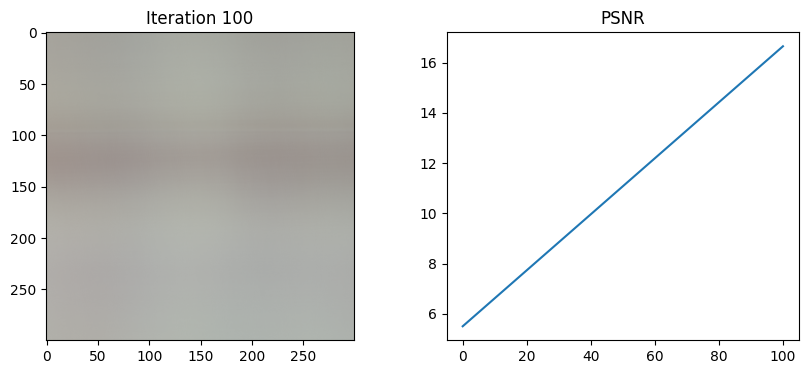

Loss: 0.01797121949493885


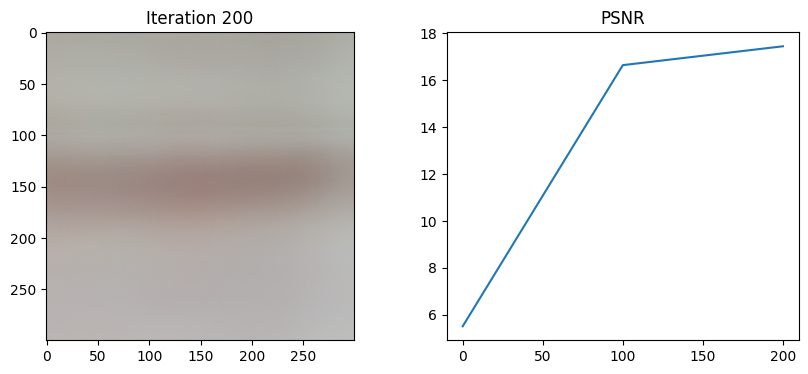

Loss: 0.017145659774541855


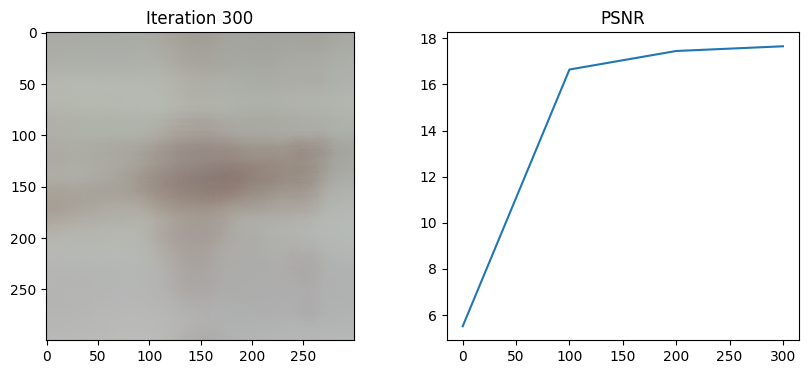

Loss: 0.011465724557638168


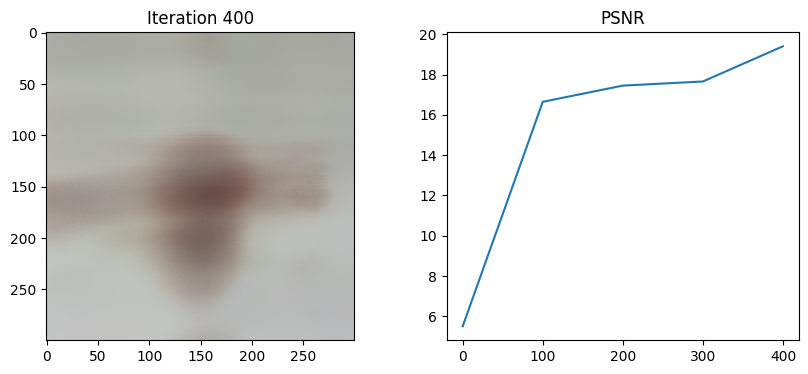

Done!


In [ ]:
for i in range(num_iters):
    # Sample image and associated pose.
    target_img_idx = np.random.randint(images.shape[0])
    target_pose = poses[target_img_idx].to(device)
    R = target_pose[:3, :3]

    # Get rotated ray origins (os) and ray directions (ds). See Section 4.
    ds = torch.einsum("ij,hwj->hwi", R, init_ds)
    os = (R @ init_o).expand(ds.shape)

    # Sample a batch of rays.
    pix_idxs = pixel_ps.multinomial(n_batch_pix, False)
    pix_idx_rows = pix_idxs // img_size
    pix_idx_cols = pix_idxs % img_size
    ds_batch = ds[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )
    os_batch = os[pix_idx_rows, pix_idx_cols].reshape(
        batch_img_size, batch_img_size, -1
    )

    # Run NeRF.
    (C_rs_c, C_rs_f) = run_one_iter_of_nerf(
        ds_batch,
        N_c,
        t_i_c_bin_edges,
        t_i_c_gap,
        os_batch,
        chunk_size,
        F_c,
        N_f,
        t_f,
        F_f,
    )
    target_img = images[target_img_idx].to(device)
    target_img_batch = target_img[pix_idx_rows, pix_idx_cols].reshape(C_rs_f.shape)
    # Calculate the mean squared error for both the coarse and fine MLP models and
    # update the weights. See Equation (6) in Section 5.3.
    loss = criterion(C_rs_c, target_img_batch) + criterion(C_rs_f, target_img_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Exponentially decay learning rate. See Section 5.3 and:
    # https://keras.io/api/optimizers/learning_rate_schedules/exponential_decay/.
    for g in optimizer.param_groups:
        g["lr"] = lr * decay_rate ** (i / decay_steps)

    if i % display_every == 0:
        F_c.eval()
        F_f.eval()
        with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
            )

        loss = criterion(C_rs_f, test_img)
        print(f"Loss: {loss.item()}")
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.figure(figsize=(10, 4))
        plt.subplot(121)
        plt.imshow(C_rs_f.detach().cpu().numpy())
        plt.title(f"Iteration {i}")
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title("PSNR")
        plt.show()

        F_c.train()
        F_f.train()

print("Done!")

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets
import numpy as np
import torch
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from torch.autograd import grad
import torch.nn.functional as nnF

def trans_t(t):
  return torch.tensor([
  [1,0,0,0],
  [0,1,0,0],
  [0,0,1,t],
  [0,0,0,1],
  ], dtype=torch.float32)

def rot_phi(phi):
    phi = torch.tensor(phi)
    return torch.tensor([
        [1, 0, 0, 0],
        [0, torch.cos(phi), -torch.sin(phi), 0],
        [0, torch.sin(phi), torch.cos(phi), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def rot_theta(th):
    th = torch.tensor(th)
    return torch.tensor([
        [torch.cos(th), 0, -torch.sin(th), 0],
        [0, 1, 0, 0],
        [torch.sin(th), 0, torch.cos(th), 0],
        [0, 0, 0, 1],
    ], dtype=torch.float32)

def pose_spherical(theta, phi, radius):
  c2w = trans_t(radius)
  c2w = rot_phi(phi/180.*np.pi) @ c2w
  c2w = rot_theta(theta/180.*np.pi) @ c2w
  c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]], dtype=torch.float32) @ c2w
  return c2w

def f(**kwargs):
  c2w = pose_spherical(**kwargs)
  c2w = c2w.to(device)
  #test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
  test_R = c2w[:3, :3].to(device)
  test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
  test_os = (test_R @ init_o).expand(test_ds.shape)
  with torch.no_grad():
            (_, C_rs_f) = run_one_iter_of_nerf(
                test_ds,
                N_c,
                t_i_c_bin_edges,
                t_i_c_gap,
                test_os,
                chunk_size,
                F_c,
                N_f,
                t_f,
                F_f,
            )

  img = torch.clamp((C_rs_f.detach()), 0, 1)
  img = img.permute(2, 0, 1)

  img_np = img.cpu().numpy()
  plt.figure(2, figsize=(20,6))
  plt.imshow(img_np.transpose(1, 2, 0))
  plt.show()

sldr = lambda v, mi, ma: widgets.FloatSlider(
  value=v,
  min=mi,
  max=ma,
  step=.01,
)

names = [
  ['theta', [100., 0., 360]],
  ['phi', [-30., -90, 0]],
  ['radius', [4., 3., 5.]],
]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

In [ ]:
frames = []
#from tqdm import tqdm_notebook as tqdm
#for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
c2w = pose_spherical(120, -30., 4.)
test_R = torch.Tensor(poses[test_idx, :3, :3]).to(device)
test_R = c2w[:3, :3].to(device)
test_ds = torch.einsum("ij,hwj->hwi", test_R, init_ds)
test_os = (test_R @ init_o).expand(test_ds.shape)
C_rs_f = run_one_iter_of_nerf(test_ds, N_c, t_i_c_bin_edges, t_i_c_gap, test_os, chunk_size, F_c, N_f, t_f, F_f)
#def run_one_iter_of_nerf(
#    ds, N_c, t_i_c_bin_edges, t_i_c_gap, os, chunk_size, F_c, N_f, t_f, F_f
#):

frames.append((C_rs_f.detach().cpu().numpy()).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

OutOfMemoryError: ignored

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)